In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_model = os.path.join(pth_data, 'modeling')
pth_in = os.path.join(pth_model, 'predict')
pth_out = os.path.join(pth_model, 'landscape')
pth_mod = os.path.join(pth_data, 'features', 'biomart', 'modules')
pth_fig = os.path.join(pth, 'figures', 'cancer', 'CCCA', 'landscape')

In [7]:
adata_plt = sc.read_h5ad(os.path.join(pth_out, 'development.h5ad'))

In [3]:
adata = sc.read_h5ad(os.path.join(pth_in, 'CCCA.h5ad'))
adata

AnnData object with n_obs × n_vars = 1406087 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'core

In [4]:
# early/late signatures
mod_names = ['Early', 'Late']
for mod in mod_names:
    print(mod)
    fn = os.path.join(pth_mod, f'{mod.lower()}.csv')
    g = pd.read_csv(fn).mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = mod,
                          random_state = 1234)
        adata.obs.loc[msk, mod] = adata_group.obs[mod]

# save basis
X = adata.obs[mod_names].values
adata.obsm['X_mod'] = X.copy()

Early
Late


In [5]:
# early-late, latent axes => landscape
dX = (X[:, 1] - X[:, 0]).reshape(-1, 1)
z = adata.obs.latent_z.values.reshape(-1, 1)
X_mesen = np.concatenate((dX, z), axis = 1)
adata.obsm['X_mesen'] = X_mesen.copy()

In [6]:
# select landscape (Early + Late > 0)
dims = ['X_mesen1', 'X_mesen2']
adata = adata[X.sum(axis = 1) > 0].copy()
adata.obs[dims] = adata.obsm['X_mesen'].copy()
adata.write(os.path.join(pth_out, 'CCCA.h5ad'))
adata

AnnData object with n_obs × n_vars = 96126 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores'

In [8]:
# landscape densities
X_ref = adata_plt.obsm['X_mesen'].copy()
scale = np.ptp(X_ref, axis = 0)
X_ref = X_ref[np.newaxis, :, :] / scale
for name, sdf in adata.obs.groupby('Name', observed = True):
    X_name = sdf[dims].values.copy()
    X_name = X_name[:, np.newaxis, :] / scale
    d = np.linalg.norm(X_name - X_ref, axis = 2)
    adata_plt.obs[name] = (d <= .1).sum(axis = 0)

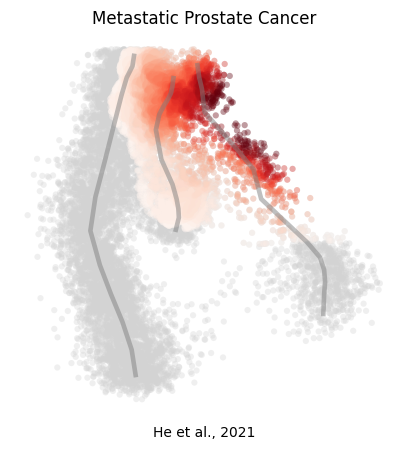

In [ ]:
name = 'Data_He2021_Prostate'
title = 'Metastatic Prostate Cancer'
txt = 'He et al., 2021'
vmin, vmax = 2, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

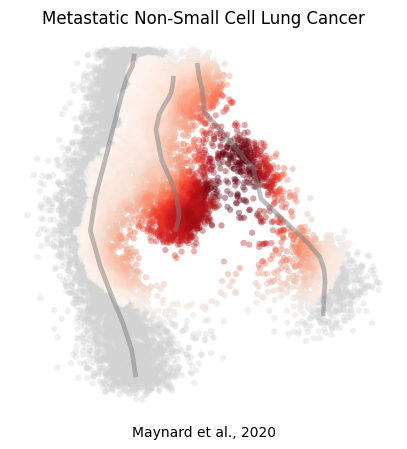

In [61]:
name = 'Data_Maynard2020_Lung'
title = 'Metastatic Non-Small Cell Lung Cancer'
txt = 'Maynard et al., 2020'
vmin, vmax = 5, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

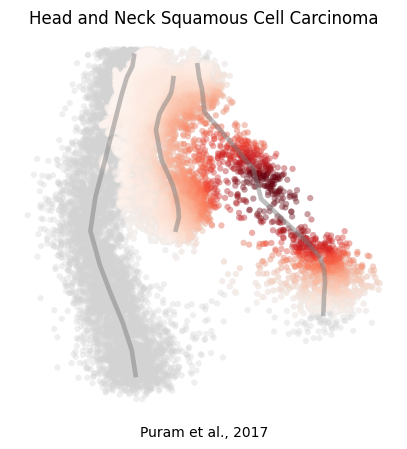

In [79]:
name = 'Data_Puram2017_Head-and-Neck'
title = 'Head and Neck Squamous Cell Carcinoma'
txt = 'Puram et al., 2017'
vmin, vmax = 6, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

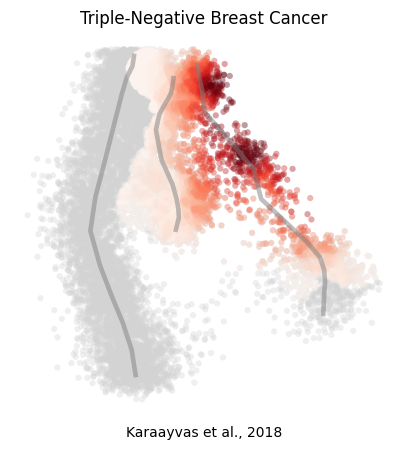

In [89]:
name = 'Data_Karaayvas2018_Breast'
title = 'Triple-Negative Breast Cancer'
txt = 'Karaayvas et al., 2018'
vmin, vmax = 3, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

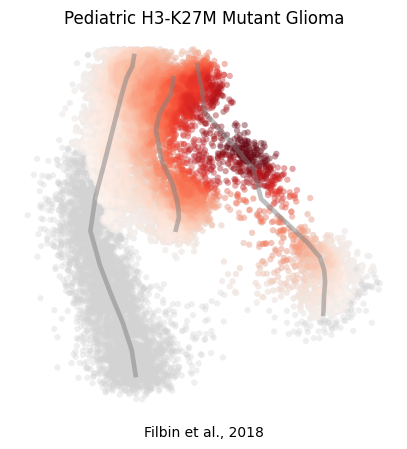

In [92]:
name = 'Data_Filbin2018_Brain'
title = 'Pediatric H3-K27M Mutant Glioma'
txt = 'Filbin et al., 2018'
vmin, vmax = 2, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

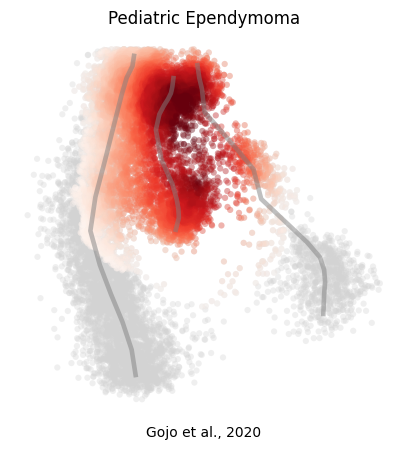

In [123]:
name = 'Data_Gojo2020_Brain'
title = 'Pediatric Ependymoma'
txt = 'Gojo et al., 2020'
vmin, vmax = 20, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

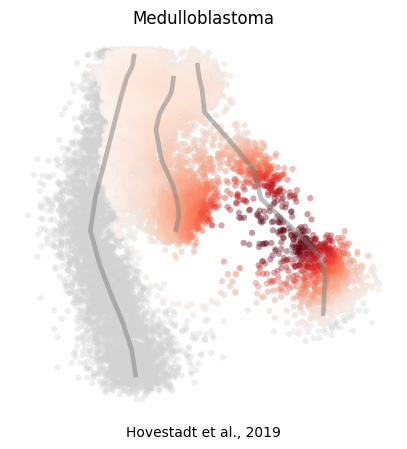

In [137]:
name = 'Data_Hovestadt2019_Brain'
title = 'Medulloblastoma'
txt = 'Hovestadt et al., 2019'
vmin, vmax = 13, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

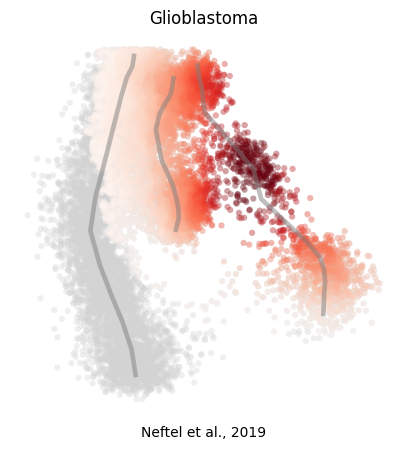

In [144]:
name = 'Data_Neftel2019_Brain'
title = 'Glioblastoma'
txt = 'Neftel et al., 2019'
vmin, vmax = 4, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

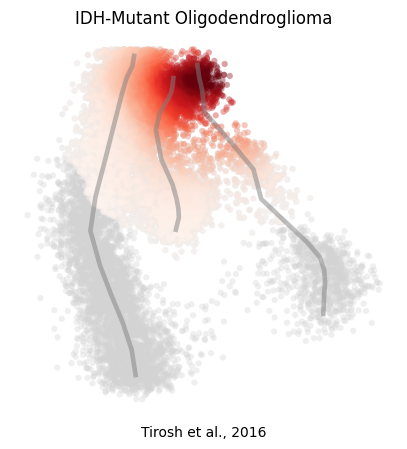

In [150]:
name = 'Data_Tirosh2016_Brain'
title = 'IDH-Mutant Oligodendroglioma'
txt = 'Tirosh et al., 2016'
vmin, vmax = 5, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

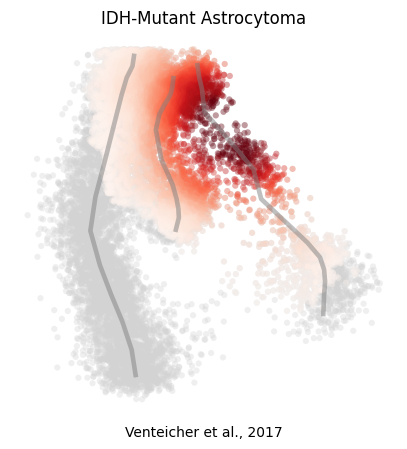

In [165]:
name = 'Data_Venteicher2017_Brain'
title = 'IDH-Mutant Astrocytoma'
txt = 'Venteicher et al., 2017'
vmin, vmax = 8, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

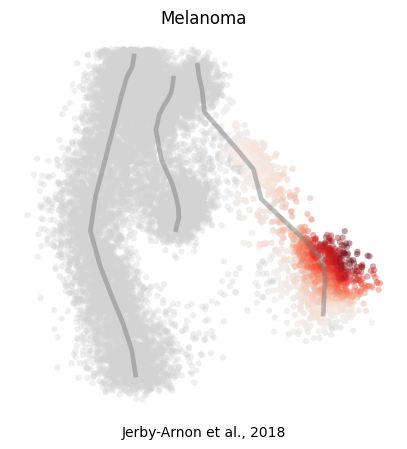

In [171]:
name = 'Data_Jerby-Arnon2018_Skin'
title = 'Melanoma'
txt = 'Jerby-Arnon et al., 2018'
vmin, vmax = 5, 'p99'

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = 'Reds', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title(title, size = 12)
ax.text(.5, -.05, txt, ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_fig, f'{name}.pdf')
plt.savefig(fn, bbox_inches = 'tight')